In [1]:
from datamatrix import io
import numpy as np
from matplotlib import pyplot as plt
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
MAX_ERR = 40
MIN_X = 4
MAX_X = 156
MIN_Y = 4
MAX_Y = 124
XC = 80
YC = 64


def mask(nft, mask):
    
    """Set voxels that match the mask to nan"""
    
    nft.get_data()[mask] = np.nan


dm = io.readpickle('../outputs/correlation-matrix.pkl')
ldm = io.readtxt('../outputs/longish-correlation-matrix.csv')
for row in dm:
    a = row.prf_err.get_data()
    x = row.prf_x.get_data()
    y = row.prf_y.get_data()
    err = np.where(
        (a > MAX_ERR) |
        (x < MIN_X) | (x >= MAX_X) |
        (y < MIN_Y) | (y >= MAX_Y)
    )
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lc, err)
dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lc = [np.nanmedian(row.r_vc_lc.get_data()) for row in dm]
dm.m_prf_err = [np.nanmedian(row.prf_err.get_data()) for row in dm]
dm.m_prf_sd = [np.nanmedian(row.prf_sd.get_data()) for row in dm]
dm.m_prf_absx = [np.nanmedian(np.abs(row.prf_x.get_data() - XC)) for row in dm]
dm.m_prf_absy = [np.nanmedian(np.abs(row.prf_y.get_data() - YC)) for row in dm]
dm.m_prf_ecc = [
    np.nanmedian(
        (
            (row.prf_y.get_data() - XC) ** 2 +
            (row.prf_y.get_data() - YC) ** 2
        ) ** .5
    )
    for row in dm
]
print('Before {}'.format(len(ldm)))
ldm = ldm.prf_err <= MAX_ERR
ldm = ldm.prf_x > MIN_X
ldm = ldm.prf_x <= MAX_X
ldm = ldm.prf_y > MIN_Y
ldm = ldm.prf_y <= MAX_Y
print('After {}'.format(len(ldm)))

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


Before 54720
After 33412


# Overall correlation per ROI

/home/sebastiaan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


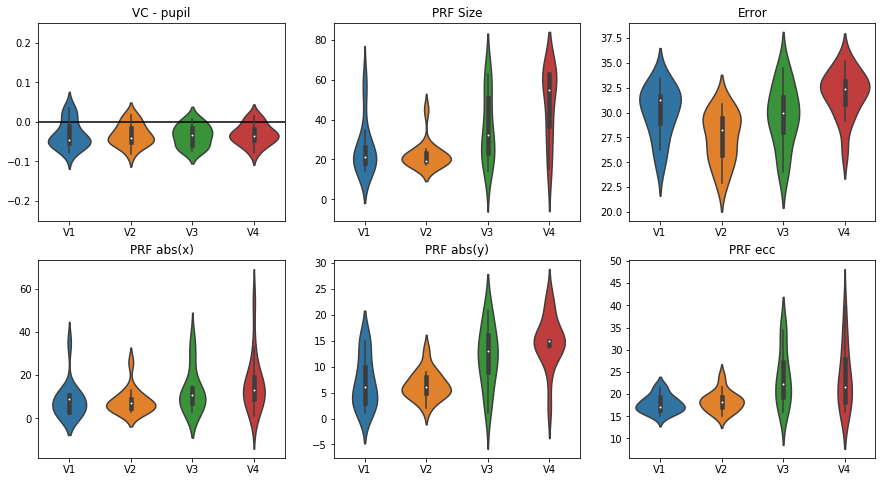

In [3]:
import seaborn as sns

plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
plt.title('VC - pupil')
plt.axhline(0, color='black')
plt.ylim(-.25, .25)
sns.violinplot(x='roi', y='r_pupil', data=dm)
plt.subplot(2,3,2)
plt.title('PRF Size')
sns.violinplot(x='roi', y='m_prf_sd', data=dm)
plt.subplot(2,3,3)
plt.title('Error')
sns.violinplot(x='roi', y='m_prf_err', data=dm)
plt.subplot(2,3,4)
plt.title('PRF abs(x)')
sns.violinplot(x='roi', y='m_prf_absx', data=dm)
plt.subplot(2,3,5)
plt.title('PRF abs(y)')
sns.violinplot(x='roi', y='m_prf_absy', data=dm)
plt.subplot(2,3,6)
plt.title('PRF ecc')
sns.violinplot(x='roi', y='m_prf_ecc', data=dm)


# Visual-field map of correlations

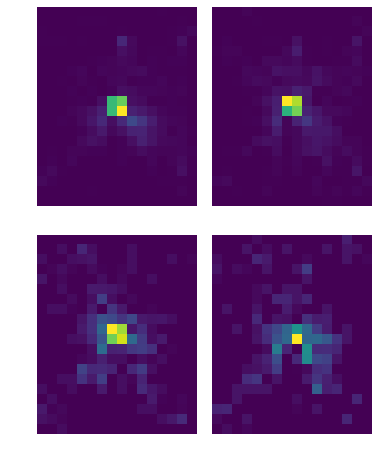

In [61]:
def density_map(ldm, downsample=8):

    a = np.zeros((2 * XC // downsample, 2 * YC // downsample))
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[x, y] += 1
    plt.axis('off')
    plt.imshow(a)
        
    
plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.subplot(2, 2, 1)    
density_map(ldm.roi == 'V1')
plt.subplot(2, 2, 2)    
density_map(ldm.roi == 'V2')
plt.subplot(2, 2, 3)    
density_map(ldm.roi == 'V3')
plt.subplot(2, 2, 4)    
density_map(ldm.roi == 'V4')

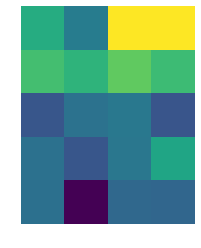

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


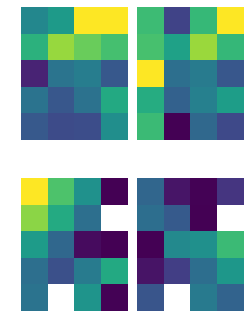

In [74]:
def correlation_map(ldm, downsample=32):

    a = np.empty((len(ldm), 2 * XC // downsample, 2 * YC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[i, x, y] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    plt.imshow(heatmap, vmin=-.06, vmax=0)
        

correlation_map(ldm, downsample=32)
plt.show()
    
plt.figure(figsize=(4, 6))
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.subplot(2, 2, 1)    
correlation_map(ldm.roi == 'V1')
plt.subplot(2, 2, 2)    
correlation_map(ldm.roi == 'V2')
plt.subplot(2, 2, 3)    
correlation_map(ldm.roi == 'V3')
plt.subplot(2, 2, 4)    
correlation_map(ldm.roi == 'V4')

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


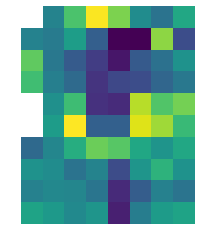

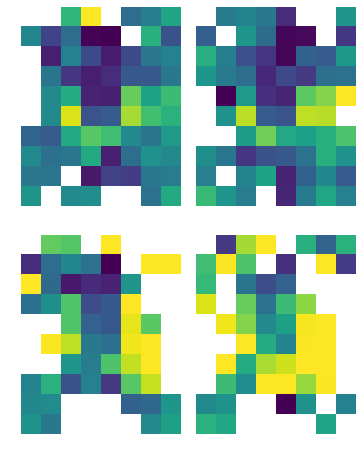

In [71]:
def size_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * XC // downsample, 2 * YC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.prf_sd
        a[i, x, y] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    plt.imshow(heatmap)
        
    
size_map(ldm)
plt.show()
plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.subplot(2, 2, 1)
size_map(ldm.roi == 'V1')
plt.subplot(2, 2, 2)    
size_map(ldm.roi == 'V2')
plt.subplot(2, 2, 3)    
size_map(ldm.roi == 'V3')
plt.subplot(2, 2, 4)    
size_map(ldm.roi == 'V4')

# Statistics

In [5]:
from datamatrix.rbridge import lme4
lme4.verbose = True

lme4.lmer(ldm, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
14.0011849555487,(Intercept),-0.0332030576251805,0.000462171771682514,0.00731313119385207,-4.54019718025753


In [6]:
ldm.c_roi = ldm.roi @ (lambda roi: 0 if roi == 'V1' else 1 if roi == 'V2' else 2 if roi == 'V3' else 3)
lme4.lmer(ldm, 'r_vc_pupil ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0006969835374,(Intercept),-0.0319683361364489,0.00214490733820834,0.00852044707542756,-3.7519552499356
13.9772713420154,c_roi,-0.00203915259858319,0.464586222004963,0.00271200604890695,-0.751898248680179


In [7]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
13.9827305193539,(Intercept),-0.0437665386681756,0.000220621277800533,0.00887008129164199,-4.93417559875302
13.9629106169063,prf_y,0.000159403361858257,0.0106854563515537,5.41353296589619e-05,2.94453479571393


In [8]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
14.0298672310224,(Intercept),-0.026009673883857,0.0175203388442714,0.00966363617186561,-2.69149970272895
14.1390855089956,prf_x,-9.58094039531381e-05,0.0770182035538719,5.02355780513054e-05,-1.90720217960443


In [9]:
lme4.lmer(ldm, 'r_vc_pupil ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
14.0173226872288,(Intercept),-0.0325351935255297,0.000783945175693157,0.00762964069425344,-4.26431529731602
14.0509572233896,ecc,-1.78805097429659e-05,0.798494428822886,6.87220725080081e-05,-0.260185833901944


In [10]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
14.0089810429816,(Intercept),-0.0262122982687863,0.0202951939617614,0.010017064703079,-2.61676439613386
14.0094754702871,prf_sd,-0.00023238119032133,0.145009310520467,0.000150561432141412,-1.54343105678665
